In [10]:
from PIL import Image
import os
import glob
import pandas as pd
import imageio
import io
import math
import string
import re
import numpy as np
import sys
import random
from sklearn.model_selection import train_test_split
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
import math
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import codecs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


# Data Set 1: Classification of Stanford Dogs

## Pre-processing

Read in images and resize to the smallest dimensions in x and y. This is to standardize the sizes of all the images. We resize to the smallest dimensions in x and y because we do not want to enlargen any images and make the images "blurrier"/ "less precise". We also initialize a data frame to contain three columns for each sample: an empty data array (for now), the filename, and the label (dog breed). We also convert the image into a grayscale image first and flatten the pixel data. Note that the number of original features is 36000, which corresponds to the RGB values for each sample (120x100x3 = 36000). Finally, we transform our data and label columns into lists. 

In [2]:
#Initialize our image_list which (will temporarily hold our images) and our dataframe
image_list = []
df = pd.DataFrame(columns = ['data','filename','label'])

#Initialize min sizes in x and y
x_min = 1000000
y_min = 1000000

rootdir = '/Users/kylelee/Desktop/ML_Project/Images'
index = 0
for root, dirs, files in os.walk(rootdir):
    #Loop through all the subdirectories
    for curDir in dirs:
        temp = 'Images/' + curDir + '/*.jpg'
        
        #Get label from directory name
        curFile = curDir.split('-',1)
        label = curFile[1]
        
        #Loop through current directory
        for filename in glob.glob(temp):
            
            #Initalize pixel data to be empty
            data = []
            
            #Append to data frame
            df.loc[index] = [data,filename,label]
            index+=1
            
            #Append to image list using the gray scale images
            im = Image.open(filename)
            x_min = min(x_min,im.size[0])
            y_min = min(y_min,im.size[1])
            image_list.append(im.copy())
            im.close()
            
print 'Minimum dimension in x:', x_min 
print 'Minimum dimension in y:', y_min

Minimum dimension in x: 97
Minimum dimension in y: 100


In [3]:
#Resize the images to all be of the smallest dimensions
for i in range(len(image_list)):
    if image_list[i].size[0] > image_list[i].size[1]:
        image_list[i] = image_list[i].resize((x_min,y_min))
    else:
        image_list[i] = image_list[i].resize((y_min,x_min))

In [4]:
#Loop through and update "data" values in the dataframe
for i in range(len(image_list)):
    rgb = np.array(image_list[i])
    rgb = rgb[...,:3]
    grey = []
    #Take rgb values and calculate the grayscale values
    for j in range (len(rgb)):
        for k in range(len(rgb[j])):
            grey.append(0.2126*int(rgb[j][k][0])+0.7152*int(rgb[j][k][1])+0.0722*int(rgb[j][k][2]))
    df.at[i,'data'] = grey

In [5]:
#Creating our X (containing our RGB data) and y (containing our labels) lists to use in PCA
temp_X = df['data']
temp_y = df['label']

X = []
y = []

for i in range(len(temp_X)):
    X.append([])
    X[i] = temp_X[i]
    y.append([])
    y[i] = temp_y[i]

## Classifier 1: Perceptron

### Feature extraction with PCA and use of classifier

Ethan Zang:
We define our K-Fold such that we split into 5 pieces. By default in Sci-Kit Learn, K-Fold splits into 5 pieces which is what we implement as well. 

Looping through each train-test combination (for each fold), we first perform PCA for feature extraction to create new features which are linear combinations of the original features. This is done by first scaling both our training and testing data to have zero mean and unit variance (fitting the scaler to our training data and applying to both training and testing data). We then use PCA with k number of components such that at least 90% of the energy is captured using k components, fitting to only the training data. The transformation obtained using the training data is then applied on both the training and testing data.

Finally, we apply a perceptron classifier that uses a one vs. all multi-class classifier and fit it to the post-PCA training features. Perceptron is a binary classifier that minimizes 0-1 loss. Using this with a one vs. all method allows for multi-class classification.

In [6]:
#Define K fold
k_fold = KFold(n_splits=5,shuffle=True)

# Initialize data frame which will contain performance metrics and performance metric lists
df_scores_perceptron = pd.DataFrame(columns = ['accuracy','f1_score'])

#Transform X and Y lists into arrays for use below
X = np.array(X)
y = np.array(y)
scores_perceptron = []
f1_score_perceptron = []
confusion_matrices_perceptron = []
index = 0

print 'Number of features before PCA: ',len(X[0])

#Loop through each of the 5 fold
for train_index, test_index in k_fold.split(X):
    #Center training data and testing data
    mean_datascaler = sklpp.StandardScaler(with_mean=True, with_std=True)
    centered_X_train = mean_datascaler.fit_transform(X[train_index])
    centered_X_test = mean_datascaler.transform(X[test_index])
    print 'Confirming testing data has mean 0: ',centered_X_test.mean()
    print 'Confirming training data has mean 0: ',centered_X_train.mean(), '\n'
    
    #Define our PCA and transform our training and testing data
    data_pca = skldecomp.PCA(n_components=0.9, svd_solver='full')
    features_X_train = data_pca.fit_transform(centered_X_train)
    features_X_test = data_pca.transform(centered_X_test)
    print 'Number of features after PCA: ',len(features_X_train[0]), '\n'
    
    #Define training features and testing features as numpy arrays
    features_X_train = np.array(features_X_train)
    features_X_test = np.array(features_X_test)
    
    #Apply one vs. rest multi-class classifier using Perceptron
    perceptronClassifier = Perceptron(random_state=0,tol=1e-3)
    perceptronClassifier.fit(features_X_train,y[train_index])
    
    #Append performance metrics
    scores_perceptron.append(perceptronClassifier.score(features_X_test,y[test_index]))
    y_predicted = perceptronClassifier.predict(features_X_test)
    f1_score_perceptron.append(f1_score(y_predicted,y[test_index], average = 'weighted'))
    confusion_matrices_perceptron.append(confusion_matrix(y_predicted,y[test_index]))
    
    #Append accuracy and f1 score for each fold in a dataframe
    df_scores_perceptron.loc[index] = [scores_perceptron[index],f1_score_perceptron[index]]
    index+=1

avg_score_perceptron = sum(scores_perceptron)/len(scores_perceptron)

Number of features before PCA:  9700
Confirming testing data has mean 0:  -0.011223168649796757
Confirming training data has mean 0:  6.279689058461915e-15 

Number of features after PCA:  757 

Confirming testing data has mean 0:  -0.0039366522735076615
Confirming training data has mean 0:  6.722166088849513e-15 

Number of features after PCA:  751 

Confirming testing data has mean 0:  0.000510811046506484
Confirming training data has mean 0:  6.764598371973144e-15 

Number of features after PCA:  760 

Confirming testing data has mean 0:  0.02267351427243572
Confirming training data has mean 0:  6.797214214097891e-15 

Number of features after PCA:  750 

Confirming testing data has mean 0:  -0.008004362455574102
Confirming training data has mean 0:  6.305776186932389e-15 

Number of features after PCA:  762 



## Classifier 2: K-Nearest Neighbors

Kyle Lee: To validate our results, we use K-Fold validation which is a common form of cross validation. We define our K-Fold such that we split into 5 pieces (K = 5). The value of K was chosen to be 5 because this is the default value for K using Sci-Kit Learn.

For each fold, we go through each train-test combination and begin by using PCA as a method of feature extraction. In doing so, we first start by centering the data to have mean 0 and unit variance. PCA is then performed such that we end up having k features where k is the number of components such that at least 90% of the energy is captured using those k features.

Finally, we apply a K-Nearest Neighbors classifier that uses a one vs. all multi-class classifier and fits to the post-PCA training features. After testing with various K values, we chose K = sqrt(N) where N is the total number of samples. This convention is also the widely used value of K. Performance metrics of accuracy and f1-score were recorded for this classifier.

In [7]:
#Define K fold
k_fold = KFold(n_splits=5,shuffle=True)

# Initialize data frame which will contain performance metrics and performance metric lists
df_scores_knn = pd.DataFrame(columns = ['accuracy','f1_score'])

#Transform X and Y lists into arrays for use below
X = np.array(X)
y = np.array(y)
scores_knn = []
f1_score_knn = []
confusion_matrices_knn = []
index = 0

print 'Number of features before PCA: ',len(X[0])

#Loop through each of the 5 fold
for train_index, test_index in k_fold.split(X):
    #Center training data and testing data
    mean_datascaler = sklpp.StandardScaler(with_mean=True, with_std=True)
    centered_X_train = mean_datascaler.fit_transform(X[train_index])
    centered_X_test = mean_datascaler.transform(X[test_index])
    print 'Confirming testing data has mean 0: ',centered_X_test.mean()
    print 'Confirming training data has mean 0: ',centered_X_train.mean(), '\n'
    
    #Define our PCA and transform our training and testing data
    data_pca = skldecomp.PCA(n_components=0.9, svd_solver='full')
    features_X_train = data_pca.fit_transform(centered_X_train)
    features_X_test = data_pca.transform(centered_X_test)
    print 'Number of new features reduced to after PCA: ',len(features_X_train[0]), '\n'
    
    #Define training features and testing features as numpy arrays
    features_X_train = np.array(features_X_train)
    features_X_test = np.array(features_X_test)
    
    #Apply one vs. rest multi-class classifier using K-NN
    knnClassifier = KNeighborsClassifier(n_neighbors=int(math.sqrt(len(features_X_train))))
    knnClassifier.fit(features_X_train,y[train_index])
    
    #Append performance metrics
    scores_knn.append(knnClassifier.score(features_X_test,y[test_index]))
    y_predicted = knnClassifier.predict(features_X_test)
    f1_score_knn.append(f1_score(y_predicted,y[test_index], average = 'weighted'))
    confusion_matrices_knn.append(confusion_matrix(y_predicted,y[test_index]))
    
    #Append accuracy and f1 score for each fold in a dataframe
    df_scores_knn.loc[index] = [scores_knn[index],f1_score_knn[index]]
    index+=1
    
avg_score_knn = sum(scores_knn)/len(scores_knn)

Number of features before PCA:  9700
Confirming testing data has mean 0:  0.013872561893486578
Confirming training data has mean 0:  6.6340334537318316e-15 

Number of new features reduced to after PCA:  751 



/Users/kylelee/opt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Confirming testing data has mean 0:  0.0009476544635580811
Confirming training data has mean 0:  6.429021141877403e-15 

Number of new features reduced to after PCA:  763 

Confirming testing data has mean 0:  -0.006473960038673719
Confirming training data has mean 0:  6.498738103816183e-15 

Number of new features reduced to after PCA:  761 

Confirming testing data has mean 0:  -0.009780671493927565
Confirming training data has mean 0:  6.707766819845421e-15 

Number of new features reduced to after PCA:  754 

Confirming testing data has mean 0:  0.0015732020368721998
Confirming training data has mean 0:  6.610255096769104e-15 

Number of new features reduced to after PCA:  751 



## Classifier 3: Gradient Descent

Joseph Edralin: In order to ensure that we have valid results, we use k-fold to cross-validate our results. We use 5 folds since it is the default setting in Sci-Kit Learn. For each iteration/combination of the folds (there are 5 in total), we first perform PCA on the data. To do so, we first center the data to have a mean of zero and a variance of 1. We then perform PCA using 90% as our threshold; in other words, we aim to reduce our data to have k features, where k is the number of components that captures 90% of the energy. At this point, we use the Gradient Descent classifier to classify our data samples using a one vs. all multiclass approach, and we record the accuracy and f1-score as performance metrics for the classifier.

In [8]:
#Define K fold
k_fold = KFold(n_splits=5,shuffle=True,random_state=0)

# Initialize data frame which will contain performance metrics and performance metric lists
df_scores_sgd = pd.DataFrame(columns = ['accuracy','f1_score'])

#Transform X and Y lists into arrays for use below
X = np.array(X)
y = np.array(y)
scores_sgd = []
f1_score_sgd = []
confusion_matrices_sgd = []
index = 0

print 'Number of features before PCA: ',len(X[0])

#Loop through each of the 5 fold
for train_index, test_index in k_fold.split(X):
    #Center training data and testing data
    mean_datascaler = sklpp.StandardScaler(with_mean=True, with_std=True)
    centered_X_train = mean_datascaler.fit_transform(X[train_index])
    centered_X_test = mean_datascaler.transform(X[test_index])
    print 'Confirming testing data has mean 0: ',centered_X_test.mean()
    print 'Confirming training data has mean 0: ',centered_X_train.mean(), '\n'
    
    #Define our PCA and transform our training and testing data
    data_pca = skldecomp.PCA(n_components=0.9, svd_solver='full')
    features_X_train = data_pca.fit_transform(centered_X_train)
    features_X_test = data_pca.transform(centered_X_test)
    print 'Number of new features reduced to after PCA: ',len(features_X_train[0]), '\n'
    
    #Define training features and testing features as numpy arrays
    features_X_train = np.array(features_X_train)
    features_X_test = np.array(features_X_test)
    
    #Apply one vs. rest multi-class classifier using K-NN
    sgdClassifier = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    sgdClassifier.fit(features_X_train,y[train_index])
    
    #Append performance metrics
    scores_sgd.append(sgdClassifier.score(features_X_test,y[test_index]))
    y_predicted = sgdClassifier.predict(features_X_test)
    f1_score_sgd.append(f1_score(y_predicted,y[test_index], average = 'weighted'))
    confusion_matrices_sgd.append(confusion_matrix(y_predicted,y[test_index]))
    
    #Append accuracy and f1 score for each fold in a dataframe
    df_scores_sgd.loc[index] = [scores_sgd[index],f1_score_sgd[index]]
    index+=1

avg_score_sgd = sum(scores_sgd)/len(scores_sgd)

Number of features before PCA:  9700
Confirming testing data has mean 0:  0.01855900727594718
Confirming training data has mean 0:  6.338342291512545e-15 

Number of new features reduced to after PCA:  750 

Confirming testing data has mean 0:  -0.005975622049933714
Confirming training data has mean 0:  6.5504692325810656e-15 

Number of new features reduced to after PCA:  767 

Confirming testing data has mean 0:  0.00903496631959359
Confirming training data has mean 0:  6.672906397781914e-15 

Number of new features reduced to after PCA:  745 

Confirming testing data has mean 0:  -0.00106452010757483
Confirming training data has mean 0:  6.850538136664397e-15 

Number of new features reduced to after PCA:  764 

Confirming testing data has mean 0:  -0.02039412106745525
Confirming training data has mean 0:  6.447670122954156e-15 

Number of new features reduced to after PCA:  755 



## Analysis of the classification methods

We display the accuracy scores and f1 scores for each of the three methods.

In [9]:
print "Performance for perceptron: \n", df_scores_perceptron, "\n"
print "Performance for KNN: \n", df_scores_knn, "\n"
print "Performance for gradient descent: \n", df_scores_sgd, "\n"
print "Confusion Matrix for Perceptron: \n", confusion_matrices_perceptron, "\n"
print "Confusion Matrix for KNN: \n", confusion_matrices_knn, "\n"
print "Confusion Matrix for SGD: \n", confusion_matrices_sgd, "\n"

Performance for perceptron: 
   accuracy  f1_score
0  0.042205  0.044922
1  0.044789  0.045306
2  0.048276  0.049546
3  0.043966  0.046344
4  0.039655  0.042388 

Performance for KNN: 
   accuracy  f1_score
0  0.064599  0.085128
1  0.064599  0.082277
2  0.053448  0.065701
3  0.063793  0.074413
4  0.050000  0.063810 

Performance for gradient descent: 
   accuracy  f1_score
0  0.068906  0.070649
1  0.061154  0.062830
2  0.077586  0.077818
3  0.081897  0.084242
4  0.085345  0.089067 

Confusion Matrix for Perceptron: 
[array([[2, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [2, 1, 4, ..., 1, 4, 0],
       ...,
       [2, 1, 0, ..., 3, 0, 2],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 3, 0, ..., 0, 1, 0]]), array([[5, 3, 5, ..., 3, 0, 0],
       [2, 0, 0, ..., 0, 0, 1],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [2, 0, 0, ..., 1, 0, 0],
       [2, 2, 2, ..., 1, 0, 1]]), array([[2, 2, 3, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 1],
 

# Data Set 2: Classification of Human Activity Recognition

## Pre-processing

Our raw csv file is organized such that the first column contains all the labels for the various activities where:
1 -> Walking,
2 -> Walking upstairs,
3 -> Walking downstairs,
4 -> Sitting,
5 -> Standing,
6 -> Laying. We thus read the first column into our y label list, drop that column from the data frame, and read the remaining data frame into the X data list of lists. Since the data is numerical and time-series related, the scaling and normalization will be done within the k-fold iterations below.

In [10]:
#Read data and store into y label list and X data list
data = pd.read_csv('HAR_Raw_Data.csv',header=None)
y = data[data.columns[0]]
data = data.drop(data.columns[0],axis=1)
X = data.values.tolist()

## Classifer 1: Perceptron

Ethan Zang:
We define our K-Fold such that we split into 5 pieces. By default in Sci-Kit Learn, K-Fold splits into 5 pieces which is what we implement as well. 

Looping through each train-test combination (for each fold), we first perform PCA for feature extraction to create new features which are linear combinations of the original features. This is done by first scaling both our training and testing data to have zero mean and unit variance (fitting the scaler to our training data and applying to both training and testing data). We then use PCA with k number of components such that at least 90% of the energy is captured using k components, fitting to only the training data. The transformation obtained using the training data is then applied on both the training and testing data.

Finally, we apply a perceptron classifier that uses a one vs. all multi-class classifier and fit it to the post-PCA training features. Perceptron is a binary classifier that minimizes 0-1 loss. Using this with a one vs. all method allows for multi-class classification.

In [11]:
#Define K fold
k_fold = KFold(n_splits=5,shuffle=True)

# Initialize data frame which will contain performance metrics and performance metric lists
df_scores_perceptron = pd.DataFrame(columns = ['accuracy','f1_score'])

#Transform X and Y lists into arrays for use below
X = np.array(X)
y = np.array(y)
scores_perceptron = []
f1_score_perceptron = []
confusion_matrices_perceptron = []
index = 0

print 'Number of features before PCA: ',len(X[0])

#Loop through each of the 5 fold
for train_index, test_index in k_fold.split(X):
    #Center training data and testing data
    mean_datascaler = sklpp.StandardScaler(with_mean=True, with_std=True)
    centered_X_train = mean_datascaler.fit_transform(X[train_index])
    centered_X_test = mean_datascaler.transform(X[test_index])
    print 'Confirming testing data has mean 0: ',centered_X_test.mean()
    print 'Confirming training data has mean 0: ',centered_X_train.mean(), '\n'
    
    #Define our PCA and transform our training and testing data
    data_pca = skldecomp.PCA(n_components=0.9, svd_solver='full')
    features_X_train = data_pca.fit_transform(centered_X_train)
    features_X_test = data_pca.transform(centered_X_test)
    print 'Number of features before PCA: ',len(X[0])
    print 'Number of features after PCA: ',len(features_X_train[0]), '\n'
    
    #Define training features and testing features as numpy arrays
    features_X_train = np.array(features_X_train)
    features_X_test = np.array(features_X_test)
    
    #Apply one vs. rest multi-class classifier using Perceptron
    perceptronClassifier = Perceptron(random_state=0,tol=1e-3)
    perceptronClassifier.fit(features_X_train,y[train_index])
    
    #Append performance metrics
    scores_perceptron.append(perceptronClassifier.score(features_X_test,y[test_index]))
    y_predicted = perceptronClassifier.predict(features_X_test)
    f1_score_perceptron.append(f1_score(y_predicted,y[test_index], average = 'weighted'))
    confusion_matrices_perceptron.append(confusion_matrix(y_predicted,y[test_index]))
    
    #Append accuracy and f1 score for each fold in a dataframe
    df_scores_perceptron.loc[index] = [scores_perceptron[index],f1_score_perceptron[index]]
    index+=1

avg_score_perceptron = sum(scores_perceptron)/len(scores_perceptron)

Number of features before PCA:  561
Confirming testing data has mean 0:  0.006605868610291353
Confirming training data has mean 0:  -3.542279394100971e-14 

Number of features before PCA:  561
Number of features after PCA:  65 

Confirming testing data has mean 0:  0.012406444739561059
Confirming training data has mean 0:  -3.60028894400796e-14 

Number of features before PCA:  561
Number of features after PCA:  65 

Confirming testing data has mean 0:  0.0008610903826463327
Confirming training data has mean 0:  -3.504394677764293e-14 

Number of features before PCA:  561
Number of features after PCA:  65 

Confirming testing data has mean 0:  -0.001502780314452276
Confirming training data has mean 0:  -3.448753768132079e-14 

Number of features before PCA:  561
Number of features after PCA:  65 

Confirming testing data has mean 0:  -0.017623217773876175
Confirming training data has mean 0:  -3.440264877225093e-14 

Number of features before PCA:  561
Number of features after PCA:  65

## Classifer 2: K-Nearest Neighbors

Kyle Lee: To validate our results, we use K-Fold validation which is a common form of cross validation. We define our K-Fold such that we split into 5 pieces (K = 5). The value of K was chosen to be 5 because this is the default value for K using Sci-Kit Learn.

For each fold, we go through each train-test combination and begin by using PCA as a method of feature extraction. In doing so, we first start by centering the data to have mean 0 and unit variance. PCA is then performed such that we end up having k features where k is the number of components such that at least 90% of the energy is captured using those k features.

Finally, we apply a K-Nearest Neighbors classifier that uses a one vs. all multi-class classifier and fits to the post-PCA training features. After testing with various K values, we chose K = sqrt(N) where N is the total number of samples. This convention is also the widely used value of K. Performance metrics of accuracy and f1-score were recorded for this classifier.

In [12]:
#Define K fold
k_fold = KFold(n_splits=5,shuffle=True)

# Initialize data frame which will contain performance metrics and performance metric lists
df_scores_knn = pd.DataFrame(columns = ['accuracy','f1_score'])

#Transform X and Y lists into arrays for use below
X = np.array(X)
y = np.array(y)
scores_knn = []
f1_score_knn = []
confusion_matrices_knn = []
index = 0

print 'Number of features before PCA: ',len(X[0])

#Loop through each of the 5 fold
for train_index, test_index in k_fold.split(X):
    #Center training data and testing data
    mean_datascaler = sklpp.StandardScaler(with_mean=True, with_std=True)
    centered_X_train = mean_datascaler.fit_transform(X[train_index])
    centered_X_test = mean_datascaler.transform(X[test_index])
    print 'Confirming testing data has mean 0: ',centered_X_test.mean()
    print 'Confirming training data has mean 0: ',centered_X_train.mean(), '\n'
    
    #Define our PCA and transform our training and testing data
    data_pca = skldecomp.PCA(n_components=0.9, svd_solver='full')
    features_X_train = data_pca.fit_transform(centered_X_train)
    features_X_test = data_pca.transform(centered_X_test)
    print 'Number of new features reduced to after PCA: ',len(features_X_train[0]), '\n'
    
    #Define training features and testing features as numpy arrays
    features_X_train = np.array(features_X_train)
    features_X_test = np.array(features_X_test)
    
    #Apply one vs. rest multi-class classifier using K-NN
    knnClassifier = KNeighborsClassifier(n_neighbors=int(math.sqrt(len(features_X_train))))
    knnClassifier.fit(features_X_train,y[train_index])
    
    #Append performance metrics
    scores_knn.append(knnClassifier.score(features_X_test,y[test_index]))
    y_predicted = knnClassifier.predict(features_X_test)
    f1_score_knn.append(f1_score(y_predicted,y[test_index], average = 'weighted'))
    confusion_matrices_knn.append(confusion_matrix(y_predicted,y[test_index]))
    
    #Append accuracy and f1 score for each fold in a dataframe
    df_scores_knn.loc[index] = [scores_knn[index],f1_score_knn[index]]
    index+=1
    
avg_score_knn = sum(scores_knn)/len(scores_knn)

Number of features before PCA:  561
Confirming testing data has mean 0:  0.006495802711953515
Confirming training data has mean 0:  -3.530875239756221e-14 

Number of new features reduced to after PCA:  65 

Confirming testing data has mean 0:  -0.01806187418376128
Confirming training data has mean 0:  -3.455290280624514e-14 

Number of new features reduced to after PCA:  65 

Confirming testing data has mean 0:  0.007229692815383457
Confirming training data has mean 0:  -3.4870394069659415e-14 

Number of new features reduced to after PCA:  65 

Confirming testing data has mean 0:  -0.005958674016294546
Confirming training data has mean 0:  -3.485514425688309e-14 

Number of new features reduced to after PCA:  65 

Confirming testing data has mean 0:  0.010710225181929347
Confirming training data has mean 0:  -3.5579004452533265e-14 

Number of new features reduced to after PCA:  65 



## Classifer 3: Gradient Descent

Joseph Edralin: In order to ensure that we have valid results, we use k-fold to cross-validate our results. We use 5 folds since it is the default setting in Sci-Kit Learn. For each iteration/combination of the folds (there are 5 in total), we first perform PCA on the data. To do so, we first center the data to have a mean of zero and a variance of 1. We then perform PCA using 90% as our threshold; in other words, we aim to reduce our data to have k features, where k is the number of components that captures 90% of the energy. At this point, we use the Gradient Descent classifier to classify our data samples using a one vs. all multiclass approach, and we record the accuracy and f1-score as performance metrics for the classifier.

In [13]:
#Define K fold
k_fold = KFold(n_splits=5,shuffle=True,random_state=0)

# Initialize data frame which will contain performance metrics and performance metric lists
df_scores_sgd = pd.DataFrame(columns = ['accuracy','f1_score'])

#Transform X and Y lists into arrays for use below
X = np.array(X)
y = np.array(y)
scores_sgd = []
f1_score_sgd = []
confusion_matrices_sgd = []
index = 0

print 'Number of features before PCA: ',len(X[0])

#Loop through each of the 5 fold
for train_index, test_index in k_fold.split(X):
    #Center training data and testing data
    mean_datascaler = sklpp.StandardScaler(with_mean=True, with_std=True)
    centered_X_train = mean_datascaler.fit_transform(X[train_index])
    centered_X_test = mean_datascaler.transform(X[test_index])
    print 'Confirming testing data has mean 0: ',centered_X_test.mean()
    print 'Confirming training data has mean 0: ',centered_X_train.mean(), '\n'
    
    #Define our PCA and transform our training and testing data
    data_pca = skldecomp.PCA(n_components=0.9, svd_solver='full')
    features_X_train = data_pca.fit_transform(centered_X_train)
    features_X_test = data_pca.transform(centered_X_test)
    print 'Number of new features reduced to after PCA: ',len(features_X_train[0]), '\n'
    
    #Define training features and testing features as numpy arrays
    features_X_train = np.array(features_X_train)
    features_X_test = np.array(features_X_test)
    
    #Apply one vs. rest multi-class classifier using Gradient Descent
    sgdClassifier = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    sgdClassifier.fit(features_X_train,y[train_index])
    
    #Append performance metrics
    scores_sgd.append(sgdClassifier.score(features_X_test,y[test_index]))
    y_predicted = sgdClassifier.predict(features_X_test)
    f1_score_sgd.append(f1_score(y_predicted,y[test_index], average = 'weighted'))
    confusion_matrices_sgd.append(confusion_matrix(y_predicted,y[test_index]))
    
    #Append accuracy and f1 score for each fold in a dataframe
    df_scores_sgd.loc[index] = [scores_sgd[index],f1_score_sgd[index]]
    index+=1

avg_score_sgd = sum(scores_sgd)/len(scores_sgd)

Number of features before PCA:  561
Confirming testing data has mean 0:  -0.010637705238992854
Confirming training data has mean 0:  -3.435091657637543e-14 

Number of new features reduced to after PCA:  65 

Confirming testing data has mean 0:  -0.010827869244078487
Confirming training data has mean 0:  -3.4464552278031306e-14 

Number of new features reduced to after PCA:  65 

Confirming testing data has mean 0:  -0.0037124836537996684
Confirming training data has mean 0:  -3.600737829625973e-14 

Number of new features reduced to after PCA:  65 

Confirming testing data has mean 0:  0.017858007209715664
Confirming training data has mean 0:  -3.5523762459472344e-14 

Number of new features reduced to after PCA:  65 

Confirming testing data has mean 0:  0.007802204518589079
Confirming training data has mean 0:  -3.4946533741924866e-14 

Number of new features reduced to after PCA:  65 



## Analysis of the classification methods

We display the accuracy scores and f1 scores for each of the three methods. Evidently, all three methods perform well with accuracies and f1 scores of >0.90 across the board. However, gradient descent appears to consistently have the best performance.

In [9]:
print "Performance for perceptron: \n", df_scores_perceptron, "\n"
print "Performance for KNN: \n", df_scores_knn, "\n"
print "Performance for gradient descent: \n", df_scores_sgd, "\n"
print "Confusion Matrix for Perceptron: \n", confusion_matrices_perceptron, "\n"
print "Confusion Matrix for KNN: \n", confusion_matrices_knn, "\n"
print "Confusion Matrix for SGD: \n", confusion_matrices_sgd, "\n"

Performance for perceptron: 
   accuracy  f1_score
0  0.058570  0.062179
1  0.045650  0.048956
2  0.045690  0.047923
3  0.046552  0.050553
4  0.047414  0.049376 

Performance for KNN: 
   accuracy  f1_score
0  0.059432  0.075053
1  0.062016  0.078675
2  0.062069  0.079869
3  0.071552  0.090958
4  0.062069  0.077182 

Performance for gradient descent: 
   accuracy  f1_score
0  0.068906  0.070649
1  0.061154  0.062830
2  0.077586  0.077818
3  0.081897  0.084242
4  0.085345  0.089067 

Confusion Matrix for Perceptron: 
[array([[1, 3, 2, ..., 0, 1, 3],
       [4, 0, 0, ..., 0, 0, 0],
       [2, 1, 6, ..., 2, 3, 4],
       ...,
       [1, 1, 0, ..., 2, 1, 1],
       [0, 0, 1, ..., 3, 1, 0],
       [2, 0, 0, ..., 2, 2, 2]]), array([[2, 1, 1, ..., 1, 0, 1],
       [1, 1, 2, ..., 0, 1, 1],
       [0, 1, 2, ..., 0, 1, 3],
       ...,
       [1, 1, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 1, 1]]), array([[2, 1, 1, ..., 0, 1, 2],
       [3, 0, 1, ..., 2, 0, 1],
 

# Data Set 3: Clustering of Health-Related Tweets

## Pre-processing

Read in text files and run through each line and use string manipulation to isolate the tweet from the entire string. This is to work with the data we are interested in which is the tweet itself, as we do not care about the time and date of the tweet or the hyperlink to the tweet. We also remove all cases of punctuation and make all the letters lowercase, as we essentially want to focus on the words themselves. Finally, for each line corresponding to a tweet for each text file, we append it to the dataframe and we do this for every text file.

We then apply the a text-to-numerical transformation using the TfIDFVectorizer class in scikit-learn. This class goes through each pre-processed tweet and keeps track of how frequently certain words appear (TF, or term frequency) and the weight of how rare certain words are across all tweets (IDF, or inverse-data-frequency). Each word across all tweets then gets assigned a TF-IDF score, which is just TFxIDF, and the output is a vector of TF-IDF scores of all words for each tweet.

In [11]:
#Loop through directories
df = pd.DataFrame(columns = ['data'])

rootdir = '/Users/kylelee/Desktop/ML_Project/Health-Tweets/'
index = 0

cluster_words = ['health','cancer','hospital','care','death']

for root, dirs, files in os.walk(rootdir):
    
    #Loop through all the text files
    for file in files:
        fileName = rootdir+file
        currFile = codecs.open(fileName,'r',errors='ignore')
        
        #if file != 'wsjhealth.txt':
        #    continue
        
        with currFile as f:
            
            #print "Failure at: ", currFile
            print(fileName)
            for line in f:
                #For each line in the text file, we split using delimiter |, and assign the tweet string to tweetTemp
                tweet = line.split('|')[-1]
                tweet = tweet.split(' http:')[0]
                
                # Modify tweet string by making letters lowercase and removing punctuation
                tweet = tweet.lower()
                tweet = tweet.translate(string.maketrans("",""), string.punctuation)
                tweet = tweet.strip()
                
                
                
                if any(word in tweet.split(' ') for word in cluster_words):
                    #Append to data frame
                    df.loc[index] = [tweet]
                    index+=1

/Users/kylelee/Desktop/ML_Project/Health-Tweets/cbchealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/.DS_Store
/Users/kylelee/Desktop/ML_Project/Health-Tweets/nprhealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/goodhealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/cnnhealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/everydayhealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/gdnhealthcare.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/nytimeshealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/bbchealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/usnewshealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/latimeshealth.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/reuters_health.txt
/Users/kylelee/Desktop/ML_Project/Health-Tweets/msnhealthnews.txt


In [12]:
#Drop duplicates
df.drop_duplicates(keep = False, inplace = True) 

In [13]:
#Apply text to numerical transformation using tfidf vectorizer
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english')
tf_idf = tf_idf_vectorizor.fit_transform(df['data'])
tf_idf_array = tf_idf.toarray()

df

,data
0,hamilton police send mental health pros to the...
1,wind turbine noise linked to only 1 health iss...
2,check expiry dates health canada advises after...
3,despite paying top dollar some military mental...
4,fake oxycontin suspected in od death of moose ...
5,seriously ill senior stuck in us cant find a h...
6,quadriplegic temporary foreign worker denied h...
7,rob ford to have cancer surgery may 11
8,rt healthcanada health canada suspends two nat...
9,health canada willing to ease fecal transplant...


## Feature extraction with PCA

We use PCA as normal. We reduce to exactly two components to be able to use clustering on a 2 dimensional axis and visualize the clusters on a plot.

In [14]:
#Apply PCA
print 'Number of features before PCA: ',len(df.at[0,'data'])
sklearn_pca = skldecomp.PCA(n_components=2, svd_solver='full')
features_X = sklearn_pca.fit_transform(tf_idf_array)
print 'Number of features after PCA: ',len(features_X[0])

Number of features before PCA:  68
Number of features after PCA:  2


## Clustering Algorithm 1: K-Means with Euclidean Distance

Ethan Zang: Here we define our K-Means class which will be used for all 3 clustering algorithms. It takes in custom distance metric and number of clusters as the parameter, and we define custom methods for assigning/ updating centroids and cluster labels. For this iteration of clustering, we apply a simple euclidean distance metric.

In [15]:
#Define our K-Means class
class KM:
    def __init__(self, k, dist_metric):
        #Assign k to be the number of clusters passed
        self.k = k
        
        #Randomly generate seed
        self.seed = np.random.seed(random.randint(1,10))
        self.dist_metric = dist_metric
        
    def assign_centroids(self, data):
        #Randomly initialize k centroids 
        initial_centroids = np.random.permutation(data.shape[0])[0:self.k]
        self.centroids = data[initial_centroids]
        return self.centroids
    
    def assign_clusters(self, data):
        #Use pairwise distance metric to calculate distance from point to centroids
        centroid_distance =  pairwise_distances(data, self.centroids, metric = self.dist_metric)
        
        #Assign point to cluster of least distance from point
        self.cluster_labels = np.argmin(centroid_distance, axis = 1)
        return  self.cluster_labels
    
    def fit(self, data):
        #Assign centroids
        self.centroids = self.assign_centroids(data)
        
        #Loop through 300 iterations of K-Means algorithm and assign cluster labels/ recalculate centroids
        for i in range(300):
            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
        return self 
    
    def predict(self, data):
        #Assign cluster
        return self.assign_clusters(data)
    
    def update_centroids(self, data):
        #Take average of all points in each cluster and assign centroid to average of data point
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
    
        return self.centroids  

/Users/kylelee/opt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


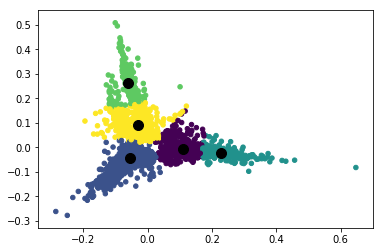

In [16]:
# Dataframe for KM Performance Metric Scores
df_scores_KM = pd.DataFrame(columns = ['ML Method', 'Davies_Bouldin_Score', 'Silhouette_Score'])

#Apply K-Means algorithm
clusterer = KM(5,'euclidean')
clustered_fit = clusterer.fit(features_X)
y_predicted = clusterer.predict(features_X)


# Performance Metric Scores for K-Means Clustering
db_score = davies_bouldin_score(features_X, y_predicted)
sil_score = silhouette_score(features_X, y_predicted)

#Append Performance Metric Scores in a dataframe
df_scores_KM.loc[0] = ['Euclidean', db_score, sil_score]

#Plot data, clusters, and centroids
plt.scatter(features_X[:, 0], features_X[:, 1], c = y_predicted, s = 20)
centroids = clustered_fit.centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'black', s = 100);

## Clustering Algorithm 2: K-Means with Cosine Distance

Kyle Lee: Using the same K-Means class defined above, KM, our second clustering algorithm will simply take in a different distance metric and the number of clusters as the parameters. For this particular iteration, we apply K-Means Clustering using the Cosine Distance Metric. This distance metric essentially measures the cosine of the angle between two vectors and projects it in a multi-dimensional space.

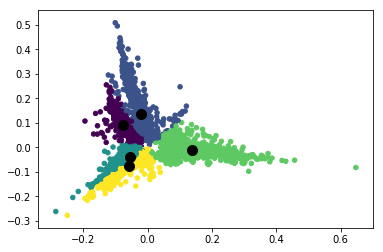

In [17]:
#Apply K-Means algorithm
clusterer = KM(5,'cosine')
clustered_fit = clusterer.fit(features_X)
y_predicted = clusterer.predict(features_X)

# Performance Metric Scores for K-Means Clustering
db_score = davies_bouldin_score(features_X, y_predicted)
sil_score = silhouette_score(features_X, y_predicted, metric = 'cosine')

#Append Performance Metric Scores in a dataframe
df_scores_KM.loc[1] = ['Cosine', db_score, sil_score]

#Plot data, clusters, and centroids
plt.scatter(features_X[:, 0], features_X[:, 1], c = y_predicted, s = 20)
centroids = clustered_fit.centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'black', s = 100);

In [41]:
df_cosine = df
df_cosine['cluster'] = y_predicted
print(df_cosine[df_cosine['cluster'] == 4])

                                                   data  cluster
7                rob ford to have cancer surgery may 11        4
13     rob ford set to have cancer surgery in early may        4
25    super seniors research to check if cancer prot...        4
35    adhd diagnosis can double risk of premature de...        4
40    why this researcher wants to end the cancer th...        4
68    cancer survivor dionne warner thrilled by husb...        4
70    breast cancer survivors tattoo artists connect...        4
75    how canadian doctor vera peters revolutionized...        4
76    ottawa mother carrying 3rd child while treatin...        4
77       cancer patient hope king passes away at age 55        4
96    spa that treated first nations girls with canc...        4
103   scientists find ancient case of human cancer i...        4
108   cancer cured by medicine man first nations man...        4
112   rt kimbrunhuber study links excess bodyweight ...        4
116   radon gas levels in

## Clustering Algorithm 3: K-Means with CityBlock Distance

Joseph Edralin: Much like the previous two clustering algorithms, we used our custom k-means class KM. KM took in the number of desired clusters and distance metric as parameters, which in this case were 5 and 'cityblock', respectively. The cityblock distance metric, which involves rectilinear distance, takes the sum of the absolute differences of the coordinates of the points being compared. For example, if Point A had the coordinates (3,8) and Point B had the coordinates (9,17), the city block distance would be d = |(17-8)| + |(9-3)| = 15.

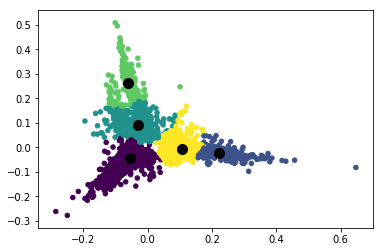

In [18]:
#Apply K-Means algorithm
clusterer = KM(5,'cityblock')
clustered_fit = clusterer.fit(features_X)
y_predicted = clusterer.predict(features_X)

# Performance Metric Scores for K-Means Clustering
db_score = davies_bouldin_score(features_X, y_predicted)
sil_score = silhouette_score(features_X, y_predicted, metric = 'cityblock')

#Append Performance Metric Scores in a dataframe
df_scores_KM.loc[2] = ['CityBlock', db_score, sil_score]

#Plot data, clusters, and centroids
plt.scatter(features_X[:, 0], features_X[:, 1], c = y_predicted, s = 20)
centroids = clustered_fit.centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'black', s = 100);

## Analysis of clustering algorithms

In [19]:
print "Performance for K-Means Clustering Methods \n"
print df_scores_KM

Performance for K-Means Clustering Methods 

   ML Method  Davies_Bouldin_Score  Silhouette_Score
0  Euclidean              0.581130          0.616322
1     Cosine              1.566156          0.778038
2  CityBlock              0.586256          0.595487
